In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pickle
import random
import train
from model import NNModelEx

pd.set_option('display.max_columns', 999)

In [2]:
# For this model, the data preprocessing part is already completed with the exception of scaling.
# so we just need to scale here.

In [3]:
def get_ref_X_y(df):
    X_cols = [c for c in df.columns if c.startswith('tc2x_')]
    y_cols = [c for c in df.columns if c.startswith('y')]
    return (df[X_cols], df[y_cols])

In [4]:
raw_data = {} # loads raw data and stores as a dict cache

def dataset_key(dataset='', validation=False):
    return dataset+('test' if validation else 'train')


def load_data(raw, dataset='', validation=False):
    '''
    Return dataframe matching data set and validation. Dictionary input will be updated.

    Parameters
    ----------
    raw : dict
        dictionary which caches the dataframes and will be updated accordingly

    dataset : str
        which dataset to use? valid input includes: empty str for full set, sample_, and secret_

    validation : bool
        load validation set? if true then use _test, otherwise use _train.  Note secret_ doesn't have _train
    '''
    key = dataset+('test' if validation else 'train')
    if key not in raw:
        print(f"Loading data to cache for: {key}")
        raw[key] = pd.read_pickle(f'./data/{key}.pkl')
    return raw[key]

In [5]:
configurations = {
    'dataset' : 't3/', # '', 'sample_', 'secret_'
    'model_identifier' : "tc2_4",
    'model_path' : f"./models",
    'model': NNModelEx,
    'device' : 'cpu',
    'random_seed' : 0,
    'lr' : 3e-3,
    'weight_decay' : 0.3, #Adam
    'max_epochs' : 50000,
    'do_validate' : True,
    'model_definition' : [
        ('l', (600,)), ('r', (True,)),
        ('l', (600,)), ('r', (True,)),
        ('l', (600,)), ('r', (True,)),
        ('l', (600,)), ('r', (True,)),
        ('l', (600,)), ('r', (True,)),
        ('l', (600,)), ('r', (True,)),
        ('l', (600,)), ('r', (True,)),
        ('l', (1,)), ('r', (True,)),
    ],
    'train_params' : {
        'batch_size': 10000,
        'shuffle': True,
        'num_workers': 3,
        'pin_memory': True,
    },
    'test_params' : {
        'batch_size': 200000,
        'num_workers': 1,
        'pin_memory': True,
    },
}

In [6]:
%%time

train_df = load_data(raw_data,dataset=configurations['dataset'],validation=False)
test_df = load_data(raw_data,dataset=configurations['dataset'],validation=True)

X_train, y_train = get_ref_X_y(train_df)
X_test, y_test = get_ref_X_y(test_df)

Loading data to cache for: t3/train


FileNotFoundError: [Errno 2] No such file or directory: './data/t3/train.pkl'

In [12]:
import torch

Loading existing model


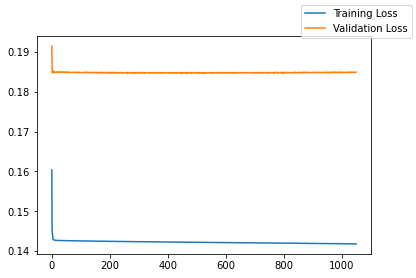

In [13]:
model, _, _, mean_losses, _ = train.load_model_with_config(configurations)

tl, vl = zip(*mean_losses)

fig,ax = plt.subplots()
ax.plot(tl, label="Training Loss")
ax.plot(vl, label="Validation Loss")

fig.legend()
plt.show()

In [14]:
mean_losses

[(0.16034583794692206, 0.1914389729499817),
 (0.1452894951142962, 0.18623706698417664),
 (0.1442809776654319, 0.18476253747940063),
 (0.14389140454549637, 0.18531224131584167),
 (0.14297119847365788, 0.18526604771614075),
 (0.14289219417269267, 0.18478699028491974),
 (0.1428396739656963, 0.1851077675819397),
 (0.14280967958389768, 0.18493270874023438),
 (0.142777414075912, 0.18505488336086273),
 (0.1427473567780994, 0.18502497673034668),
 (0.14272637925450765, 0.18480533361434937),
 (0.14273009224543495, 0.18481355905532837),
 (0.14271560334970082, 0.18485386669635773),
 (0.14268496017607432, 0.18492965400218964),
 (0.14267278521779983, 0.18494731187820435),
 (0.14265660539505973, 0.184967041015625),
 (0.14266815403151134, 0.18494117259979248),
 (0.14266385469171736, 0.18496759235858917),
 (0.1426587291653194, 0.18501316010951996),
 (0.1426580548286438, 0.1849094182252884),
 (0.14266786996334319, 0.18488141894340515),
 (0.14266824745942677, 0.18489941954612732),
 (0.14264621975876035, 

In [15]:
trained_model = model

In [16]:
y_train_pred = train.predict(trained_model, X_train, y_train, device="cpu") # get predictions for each train
y_train_pred_df = pd.DataFrame(y_train_pred, columns=y_train.columns)  # put results into a dataframe

NameError: name 'X_train' is not defined

In [17]:
print(f'    Train set MAE (L1) loss: {mean_absolute_error(y_train, y_train_pred_df)}')
print(f'    Train set MSE (L2) loss: {mean_squared_error(y_train, y_train_pred_df)}')

# random.seed(0)
# sample = random.sample(list(y_train_pred_df.index), 10)

print("Train")
train_res = pd.concat([y_train, y_train_pred_df], axis=1)
train_res.columns = ['Ground Truth', 'Pred']
train_res['binarize'] = (train_res['Pred'] > 0.5).astype(float)
train_res['correct'] = train_res['Ground Truth'] == train_res['binarize']
display(train_res)

NameError: name 'y_train' is not defined

In [18]:
train_res[train_res['Ground Truth']==1]['correct'].value_counts()

NameError: name 'train_res' is not defined

In [19]:
train_res[train_res['Ground Truth']==0]['correct'].value_counts()

NameError: name 'train_res' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, (y_train_pred > 0.5))